### 데이터는 어떻게 하나요?

일반적으로 이미지나 텍스트, 오디오나 비디오 데이터를 다룰 때는 표준 Python 패키지를 이용하여 Numpy 배열로 불러오면 됩니다. 그 후 배열을 `torch.*Tensor`로 변환합니다.
* 이미지는 Pillow나 OpenCV 같은 패키지가 유용합니다.
* 오디오를 처리할 때는 SciPy와 LibROSA가 유용하고요.
* 텍스트의 경우에는 그냥 Python이나 Cython을 사용해도 되고, NLTK나 SpaCy도 유용합니다.

특별히 영상 분야를 위한 `torchvision`이라는 패키지가 만들어져 있는데, 여기에는 Imagenet이나 CIFAR10, MNIST 등과 같이 일반적으로 사용하는 데이터셋을 위한 데이터 로더(data loader), 즉 `torchvision.datasets`과 이미지용 데이터 변환기(data transformer), 즉 `torch.utils.data.DataLoader`가 포함되어 있습니다.<br>
이러한 기능은 엄청나게 편리하며, 매번 유사한 코드(boilerplate code)를 반복해서 작성하는 것을 피할 수 있습니다.

# 이미지 분류기 학습하기

1. `torchvision`을 사용하여 CIFAR10의 학습용/시험용 데이터셋을 불러오고, 정규화(normalizing)합니다.
2. 합성곱 신경망(Convolution Neural Network)을 정의합니다.
3. 손실 함수를 정의합니다.
4. 학습용 데이터를 사용하여 신경망을 학습합니다.
5. 시험용 데이터를 사용하여 신경망을 검사합니다.

# 1. CIFAR10를 불러오고 정규화하기

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True,
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True,num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


---
### Understaning transform.Normalize(mean, std, inplace=Flase)
---

https://discuss.pytorch.org/t/understanding-transform-normalize/21730

Normalize dose the following for each channel:<br>
`image = (image - mean) / std`<br>
The parameters `mean, std` are passed as 0.5, 0.5 in our case. This will normalize the image in the range \[-1,1\]. For example, the minimum value 0 will be converted to `(0-0.5)/0.5 = -1`, the maximum value of 1 will be converted to `(1-0.5)/0.5=1.`<br>
If you would like to get your image back in \[0,1\] range, you could use,<br>
`image = ((image * std) + mean)`<br>
About whether it helps CNN to learn better, I'm not sure. But majority of the papers I read employ some normalization schema. What you are following is one of them.


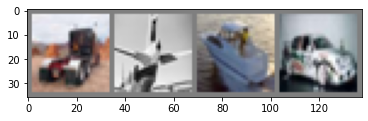

truck  plane   ship    car


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img/2 + 0.5   # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print('  '.join('%5s'%classes[labels[j]] for j in range(4)))

# 2. 합성곱 신경망(Convolution Neural Network) 정의하기